In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy
import scipy
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from IPython.display import Image

import h5py

import pycbc
import pycbc.noise
#import pycbc.psd
import pycbc.waveform
import pycbc.frame
import pycbc.filter
import pycbc.detector
from pycbc import DYN_RANGE_FAC

from glue.ligolw import ligolw
from glue.ligolw import lsctables
from glue.ligolw import utils as ligolw_utils

import os
import sys
import h5py
import logging
import numpy
import pycbc
from pycbc.distributions import JointDistribution
from pycbc.filter import matched_filter, resample_to_delta_t
from pycbc.inject import InjectionSet
from pycbc.noise.reproduceable import colored_noise
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.workflow import WorkflowConfigParser
from pycbc import distributions
from pycbc import strain as _strain
from pycbc import psd as _psd
from scipy.optimize import brentq

from IPython.display import Image

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import logging
logger = logging.getLogger('matplotlib')
logger.setLevel('INFO')
rcParams['figure.figsize']=(14,7)
rcParams['text.usetex'] = True
rcParams.update({'font.size': 12})
plt.rc('text.latex', preamble=r"""\usepackage{amsmath}
\makeatletter
\newsavebox\myboxA
\newsavebox\myboxB
\newlength\mylenA

\newcommand*\xoverline[2][0.75]{%
    \sbox{\myboxA}{$\m@th#2$}%
    \setbox\myboxB\null% Phantom box
    \ht\myboxB=\ht\myboxA%
    \dp\myboxB=\dp\myboxA%
    \wd\myboxB=#1\wd\myboxA% Scale phantom
    \sbox\myboxB{$\m@th\overline{\copy\myboxB}$}%  Overlined phantom
    \setlength\mylenA{\the\wd\myboxA}%   calc width diff
    \addtolength\mylenA{-\the\wd\myboxB}%
    \ifdim\wd\myboxB<\wd\myboxA%
       \rlap{\hskip 0.5\mylenA\usebox\myboxB}{\usebox\myboxA}%
    \else
        \hskip -0.5\mylenA\rlap{\usebox\myboxA}{\hskip 0.5\mylenA\usebox\myboxB}%
    \fi}
\makeatother
""")


## Generate a PSD to color the noise

Read L1 PSD at delta_f = 0.005 Hz
Interpolated to delta_f = 0.00390625 Hz
Zero out frequencies below 20.0 Hz


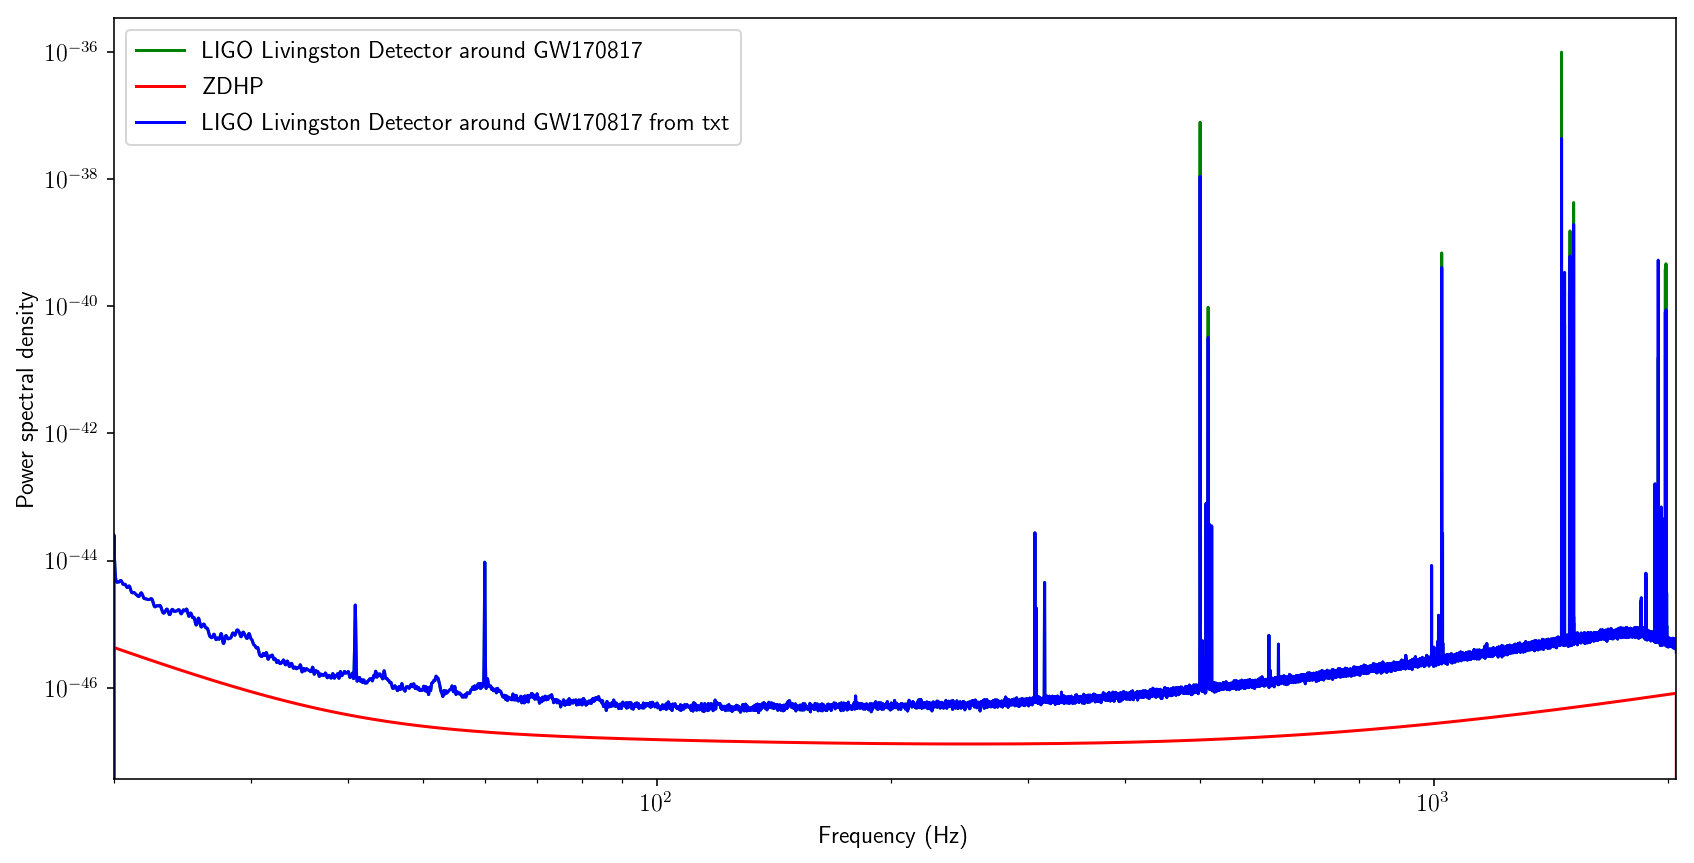

In [4]:
f_low = 20.0
delta_t = 1./4096.
N = 1048576
f_len = N/2+1
delta_f = 1./(N*delta_t)

f = h5py.File('/home/soumi.de/projects/cbc/inference_for_events/GW170817_EOS/production_runs/symmetric_lambda_common_comp_radius/uniformmass_noqcut_lambdatildecut_m1gtm2_lowfreq20hz/cropped_psdtime_gpstime/burnin_maxposterior_bothspins_fixradecdist4993/tf2_fupperISCO_srate4096/emcee_pt/H1L1V1/inference.hdf.checkpoint','r')
l1_samples = f["L1"]["psds"]["0"]
l1_delta_f = f["L1"]["psds"]["0"].attrs["delta_f"]
l1_psd = pycbc.types.frequencyseries.FrequencySeries(l1_samples,delta_f=l1_delta_f)

print "Read L1 PSD at delta_f = {} Hz".format(l1_delta_f)
l1_psd = pycbc.psd.estimate.interpolate(l1_psd,delta_f) / (DYN_RANGE_FAC*DYN_RANGE_FAC)
print "Interpolated to delta_f = {} Hz".format(delta_f)

print "Zero out frequencies below {} Hz".format(f_low)
low_freq_idx = [l1_psd.sample_frequencies < f_low]
for i in low_freq_idx:
    l1_psd.data[i] = 0

aligo_psd = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, f_low)

l1_psd_from_txt = pycbc.psd.from_txt('/home/soumi.de/projects/cbc/GW170817_injection_study/psds_used_in_prl_runs/L1_gw170817.txt', f_len, delta_f,
                                  f_low,is_asd_file=False)
low_freq_idx = [l1_psd.sample_frequencies < f_low]
for i in low_freq_idx:
    l1_psd_from_txt.data[i] = 0

plt.loglog(l1_psd.sample_frequencies,l1_psd,color='g',
           label='LIGO Livingston Detector around GW170817')
plt.loglog(aligo_psd.sample_frequencies,aligo_psd,color='r',label='ZDHP')
plt.loglog(l1_psd_from_txt.sample_frequencies,l1_psd_from_txt,color='b',label='LIGO Livingston Detector around GW170817 from txt')
plt.xlim([20.,2048])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.legend(loc='best')
plt.show()

## Check SNR for a GW170817-like injection inserted into pre-saved ASD (noise) files

### rescale to distance of SNR=80, compute recovered SNR and print scaled distance

In [3]:
instruments = ["H1", "L1", "V1"]
injections_file = 'injection_GW170817.hdf'
gps_start_time = 1187008641
gps_end_time = 1187008941
sample_rate = 4096
low_frequency_cutoff = 20
output_file = 'gw170817_inj.hdf'

def inject_and_filter(params, noise_strain, psd_dict):
    # set initial distance so signal will be loud
    #logging.info("Setting initial distance to {} Mpc".format(float(initial_distance)))
    
    params['ra'] = 4.25460328757
    params['dec'] = -0.573656562718
    params['lambda1'] = 174
    params['lambda2'] = 478
    # write injection file
    logging.info("Writing injection file")
    with h5py.File(output_file, "w") as fp:
        for p, v in params.items():
            fp.create_dataset(p, (1,), data=v)
    # generate template waveform
    logging.info("Generating template waveform")
    print("delta_f=", delta_f)
    hp, hc = get_fd_waveform(approximant=params['approximant'],
                             mass1=params['mass1'],
                             mass2=params['mass2'],
                             spin1z=params['spin1z'],
                             spin2z=params['spin2z'],
                             lambda1=params['lambda1'],
                             lambda2=params['lambda2'],
                             distance=params['distance'],
                             tc=params['tc'],
                             ra=params['ra'],
                             dec=params['dec'],
                             inclination=params['inclination'],
                             polarization=params['polarization'],
                             coa_phase=params['coa_phase'],
                             f_lower=params['f_lower'],
                             f_ref=params['f_ref'],
                             delta_f=delta_f)
    
    network_snr = 0.0
    tcs = {}
    for ifo in instruments:
        # make injection into noise
        logging.info("Injecting waveform into {} noise".format(ifo))
        signal_strain = noise_strain[ifo].copy()
        psd = psd_dict[ifo].copy()
        injector = InjectionSet(output_file)
        injector.apply(signal_strain, ifo)
        injector._injhandler.filehandler.close()
        # matched filter template with injected signal to check SNR
        logging.info("Matched filtering template against injected signal")
        if signal_strain.delta_f != psd.delta_f:
            logging.info("Interpolating PSD")
            psd = _psd.interpolate(psd, signal_strain.delta_f)
        signal_strain = signal_strain.to_frequencyseries()
        hp.resize(len(signal_strain))
        snr_series = matched_filter(hp, signal_strain, psd=psd,
                                    low_frequency_cutoff=params['f_lower'])
        
        snr_series = snr_series.time_slice(gps_start_time+8, gps_end_time-8)
        plt.plot(snr_series.sample_times, abs(snr_series))
        plt.show()
        snr, loc = snr_series.abs_max_loc()
        print("At {:.3f} Mpc, SNR in {} is {:.3f} at time {:.4f}".format(params['distance'], ifo, snr, snr_series.sample_times[loc]))
        tcs[ifo] = snr_series.sample_times[loc]
        network_snr += snr ** 2
        
    print("network_snr={:.3f}".format(numpy.sqrt(network_snr)))
        
        
    
    params['distance'] = params['distance']*(numpy.sqrt(network_snr)/80.0)
    # write injection file
    logging.info("Writing injection file")
    with h5py.File(output_file, "w") as fp:
        for p, v in params.items():
            fp.create_dataset(p, (1,), data=v)
    # generate template waveform
    logging.info("Generating template waveform")
    print("delta_f=", delta_f)
    hp, hc = get_fd_waveform(approximant=params['approximant'],
                             mass1=params['mass1'],
                             mass2=params['mass2'],
                             spin1z=params['spin1z'],
                             spin2z=params['spin2z'],
                             lambda1=params['lambda1'],
                             lambda2=params['lambda2'],
                             distance=params['distance'],
                             tc=params['tc'],
                             ra=params['ra'],
                             dec=params['dec'],
                             inclination=params['inclination'],
                             polarization=params['polarization'],
                             coa_phase=params['coa_phase'],
                             f_lower=params['f_lower'],
                             f_ref=params['f_ref'],
                             delta_f=delta_f)
    
    network_snr = 0.0
    tcs = {}
    for ifo in instruments:
        # make injection into noise
        logging.info("Injecting waveform into {} noise".format(ifo))
        signal_strain = noise_strain[ifo].copy()
        psd = psd_dict[ifo].copy()
        injector = InjectionSet(output_file)
        injector.apply(signal_strain, ifo)
        injector._injhandler.filehandler.close()
        # matched filter template with injected signal to check SNR
        logging.info("Matched filtering template against injected signal")
        if signal_strain.delta_f != psd.delta_f:
            logging.info("Interpolating PSD")
            psd = _psd.interpolate(psd, signal_strain.delta_f)
        signal_strain = signal_strain.to_frequencyseries()
        hp.resize(len(signal_strain))
        snr_series = matched_filter(hp, signal_strain, psd=psd,
                                    low_frequency_cutoff=params['f_lower'])
        
        snr_series = snr_series.time_slice(gps_start_time+8, gps_end_time-8)
        plt.plot(snr_series.sample_times, abs(snr_series))
        plt.show()
        snr, loc = snr_series.abs_max_loc()
        print("At {:.3f} Mpc, SNR in {} is {:.3f} at time {:.4f}".format(params['distance'], ifo, snr, snr_series.sample_times[loc]))
        tcs[ifo] = snr_series.sample_times[loc]
        network_snr += snr ** 2
    
    
    
    #network_snr = numpy.sqrt(network_snr)
    #scaled_distance = params['distance'] * network_snr / target
    #logging.info("Scaling distance to {:.3f} Mpc".format(scaled_distance))
    print("new_network_snr={:.3f} at distance={:.3f}".format(numpy.sqrt(network_snr), params['distance']))
    return params['distance']
    
    
    
fp=h5py.File(injections_file,'r')

params={}
for sa in fp.attrs['static_args']:
    params[sa] = fp.attrs[sa]
    params['approximant'] = fp.attrs['approximant']
    params['f_lower'] = fp.attrs['f_lower']
    params['f_ref'] = fp.attrs['f_ref']

td_samples = (gps_end_time - gps_start_time) * sample_rate  # time domain samples
fd_samples = int(td_samples // 2) + 1  # frequency domain samples
delta_t = 1./sample_rate
delta_f = 1./(float(td_samples) * delta_t)

base_dir = "/home/soumi.de/projects/cbc/GW170817_injection_study/psds_used_in_prl_runs"
asd_files = {"H1": base_dir+"/H1_gw170817_asd.txt",
             "L1": base_dir+"/L1_gw170817_asd.txt",
             "V1": base_dir+"/V1_gw170817_asd.txt"}

psd_dict = {}
for ifo in instruments:
    print(asd_files[ifo])
    psd_dict[ifo] = _psd.from_txt(asd_files[ifo], fd_samples, delta_f,
                                  low_frequency_cutoff, is_asd_file=True)

# generate colored gaussian noise
logging.info("Generating colored gaussian noise")
noise_strain = {}
for ifo in instruments:
    noise_strain[ifo] = colored_noise(psd_dict[ifo], gps_start_time,
                                      gps_end_time,
                                      low_frequency_cutoff=low_frequency_cutoff)
    noise_strain[ifo] = resample_to_delta_t(noise_strain[ifo],delta_t=delta_t)


scaled_distance = inject_and_filter(params, noise_strain,
                                psd_dict)

/home/soumi.de/projects/cbc/GW170817_injection_study/psds_used_in_prl_runs/H1_gw170817_asd.txt


FileNotFoundError: /home/soumi.de/projects/cbc/GW170817_injection_study/psds_used_in_prl_runs/H1_gw170817_asd.txt not found.

## Check SNR for a GW170817-like injection inserted into aLIGODesignSensitivityP1200087

### rescale to distance of SNR=80, compute recovered SNR and print scaled distance

In [4]:
instruments = ["H1", "L1", "V1"]
injections_file = 'injection_test/injection_GW170817.hdf'
gps_start_time = 1187008641
gps_end_time = 1187008941
sample_rate = 4096
low_frequency_cutoff = 20
output_file = 'injection_test/gw170817_inj.hdf'

def inject_and_filter(params, noise_strain, psd_dict):
    # set initial distance so signal will be loud
    #logging.info("Setting initial distance to {} Mpc".format(float(initial_distance)))
    
    params['ra'] = 4.25460328757
    params['dec'] = -0.573656562718
    params['lambda1'] = 174
    params['lambda2'] = 478
    # write injection file
    logging.info("Writing injection file")
    with h5py.File(output_file, "w") as fp:
        for p, v in params.items():
            fp.create_dataset(p, (1,), data=v)
    # generate template waveform
    logging.info("Generating template waveform")
    print("delta_f=", delta_f)
    hp, hc = get_fd_waveform(approximant=params['approximant'],
                             mass1=params['mass1'],
                             mass2=params['mass2'],
                             spin1z=params['spin1z'],
                             spin2z=params['spin2z'],
                             lambda1=params['lambda1'],
                             lambda2=params['lambda2'],
                             distance=params['distance'],
                             tc=params['tc'],
                             ra=params['ra'],
                             dec=params['dec'],
                             inclination=params['inclination'],
                             polarization=params['polarization'],
                             coa_phase=params['coa_phase'],
                             f_lower=params['f_lower'],
                             f_ref=params['f_ref'],
                             delta_f=delta_f)
    
    network_snr = 0.0
    tcs = {}
    for ifo in instruments:
        # make injection into noise
        logging.info("Injecting waveform into {} noise".format(ifo))
        signal_strain = noise_strain[ifo].copy()
        psd = psd_dict[ifo].copy()
        injector = InjectionSet(output_file)
        injector.apply(signal_strain, ifo)
        injector._injhandler.filehandler.close()
        # matched filter template with injected signal to check SNR
        logging.info("Matched filtering template against injected signal")
        if signal_strain.delta_f != psd.delta_f:
            logging.info("Interpolating PSD")
            psd = _psd.interpolate(psd, signal_strain.delta_f)
        signal_strain = signal_strain.to_frequencyseries()
        hp.resize(len(signal_strain))
        snr_series = matched_filter(hp, signal_strain, psd=psd,
                                    low_frequency_cutoff=params['f_lower'])
        
        snr_series = snr_series.time_slice(gps_start_time+8, gps_end_time-8)
        plt.plot(snr_series.sample_times, abs(snr_series))
        plt.show()
        snr, loc = snr_series.abs_max_loc()
        print("At {:.3f} Mpc, SNR in {} is {:.3f} at time {:.4f}".format(params['distance'], ifo, snr, snr_series.sample_times[loc]))
        tcs[ifo] = snr_series.sample_times[loc]
        network_snr += snr ** 2
        
    print("network_snr={:.3f}".format(numpy.sqrt(network_snr)))
        
    return numpy.sqrt(network_snr)
    
    
    
fp=h5py.File(injections_file,'r')

params={}
for sa in fp.attrs['static_args']:
    params[sa] = fp.attrs[sa]
    params['approximant'] = fp.attrs['approximant']
    params['f_lower'] = fp.attrs['f_lower']
    params['f_ref'] = fp.attrs['f_ref']

td_samples = (gps_end_time - gps_start_time) * sample_rate
fd_samples = int(td_samples // 2) + 1
delta_t = 1./sample_rate
delta_f = 1./(float(td_samples) * delta_t)


psd_dict = {}
psd_dict['H1'] = _psd.aLIGODesignSensitivityP1200087(fd_samples, delta_f, low_frequency_cutoff)
psd_dict['L1'] = _psd.aLIGODesignSensitivityP1200087(fd_samples, delta_f, low_frequency_cutoff)
psd_dict['V1'] = _psd.AdVDesignSensitivityP1200087(fd_samples, delta_f, low_frequency_cutoff)

# generate colored gaussian noise
logging.info("Generating colored gaussian noise")
noise_strain = {}
seed=1
for ifo in instruments:
    noise_strain[ifo] = colored_noise(psd_dict[ifo], gps_start_time,
                                      gps_end_time,seed=seed,
                                      low_frequency_cutoff=low_frequency_cutoff)
    noise_strain[ifo] = resample_to_delta_t(noise_strain[ifo],delta_t=delta_t)
    seed+=1


network_snr = inject_and_filter(params, noise_strain,
                                psd_dict)

delta_f= 0.0033333333333333335


ValueError: Approximant b'IMRPhenomD_NRTidal' not available

## Inject at a closer distance so that SNR is ~200, print recovered network SNR

('delta_f=', 0.0033333333333333335)


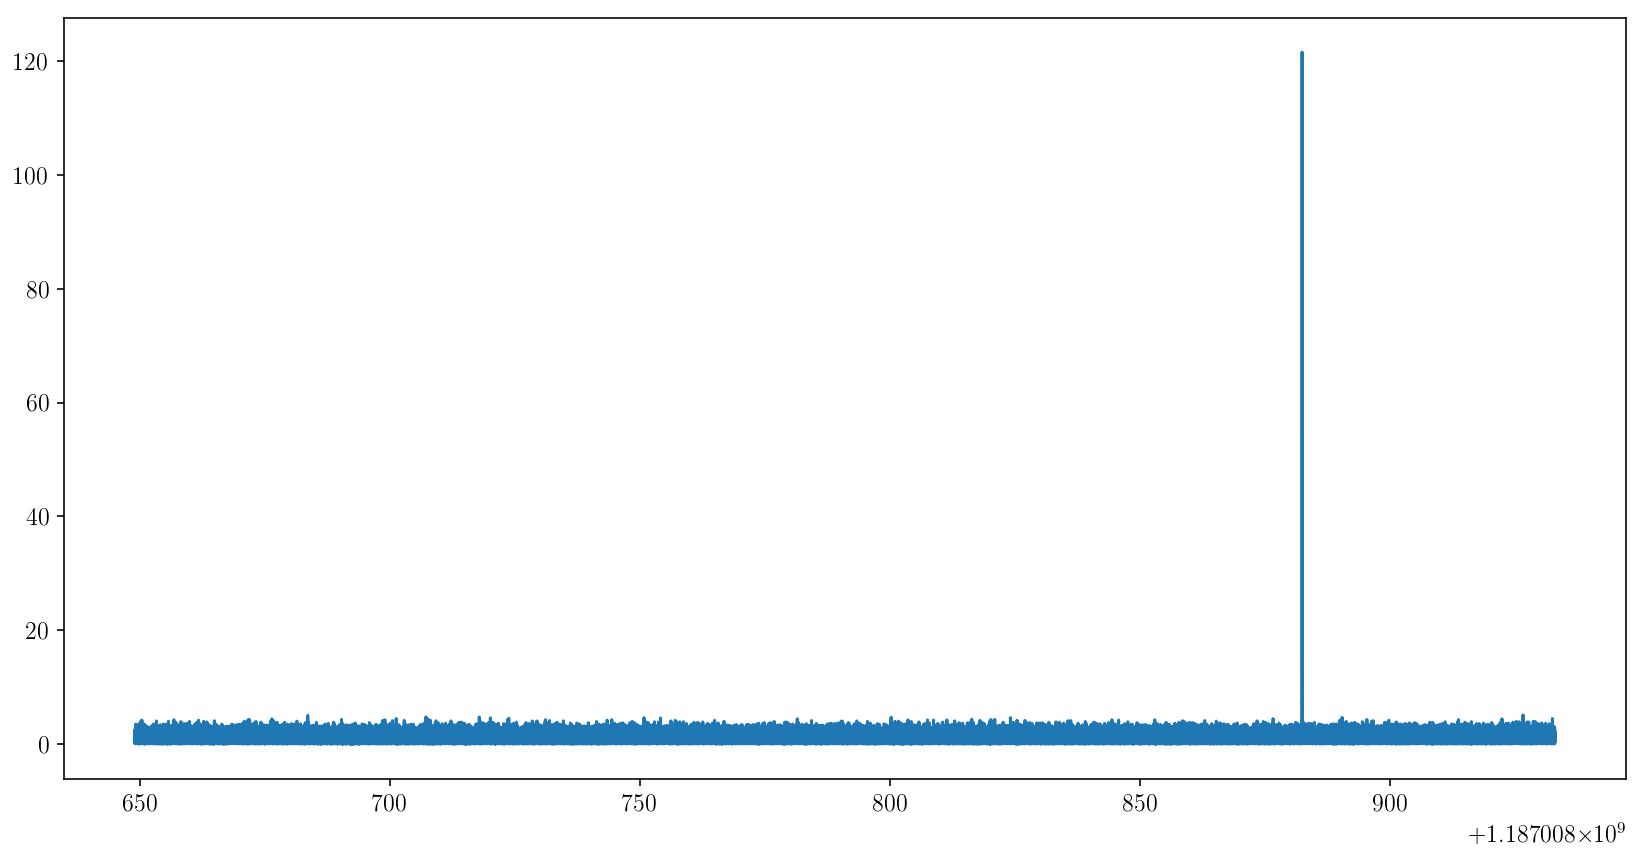

At 22.540 Mpc, SNR in H1 is 121.596 at time 1187008882.4475


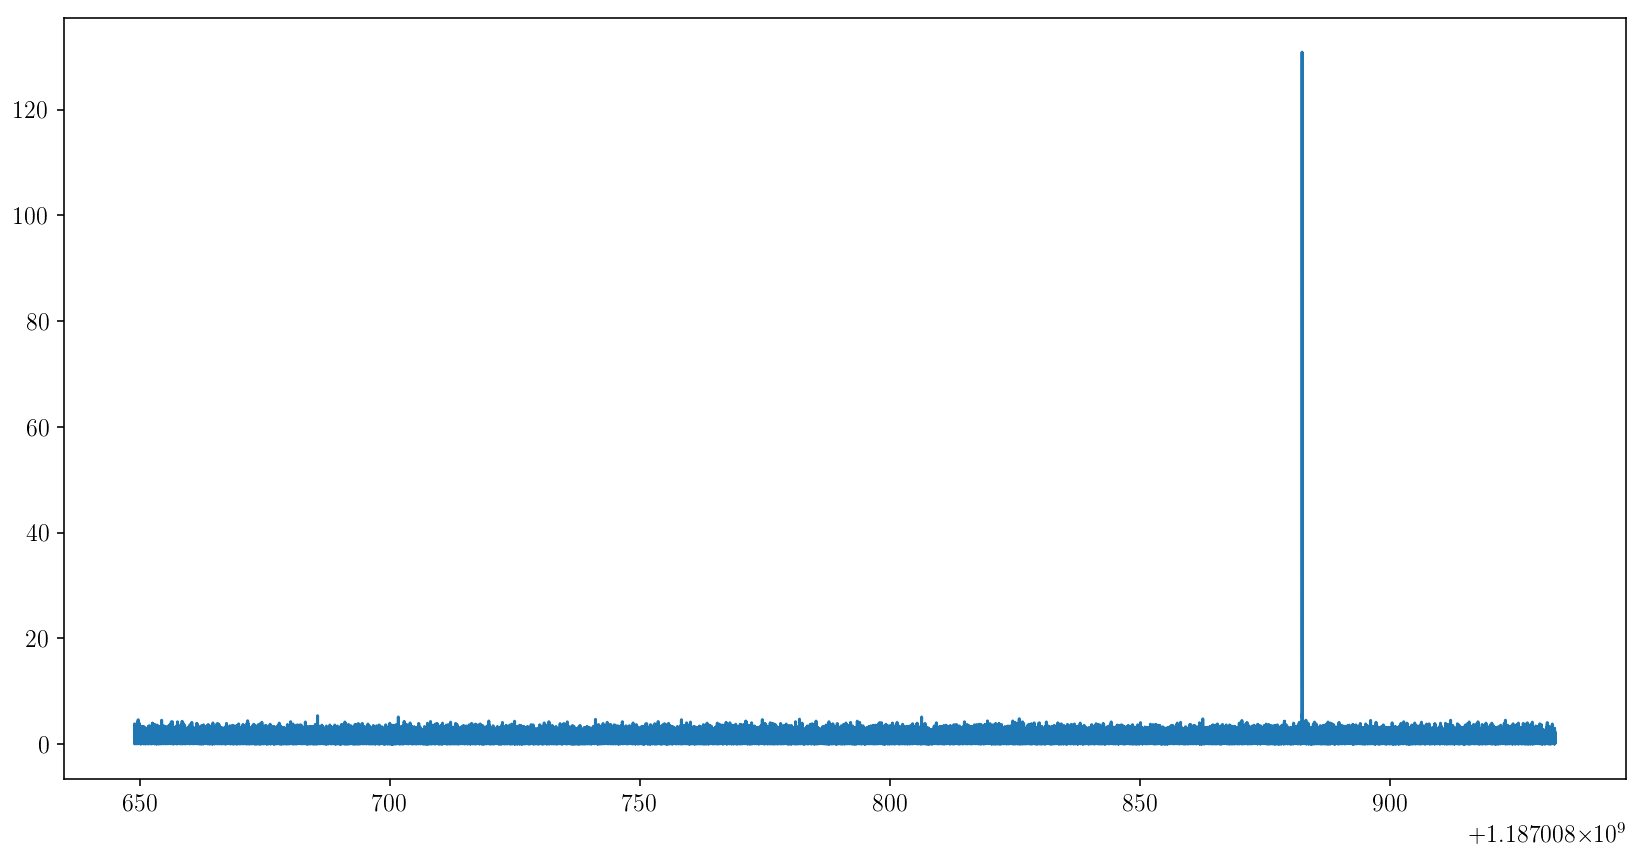

At 22.540 Mpc, SNR in L1 is 130.847 at time 1187008882.4495


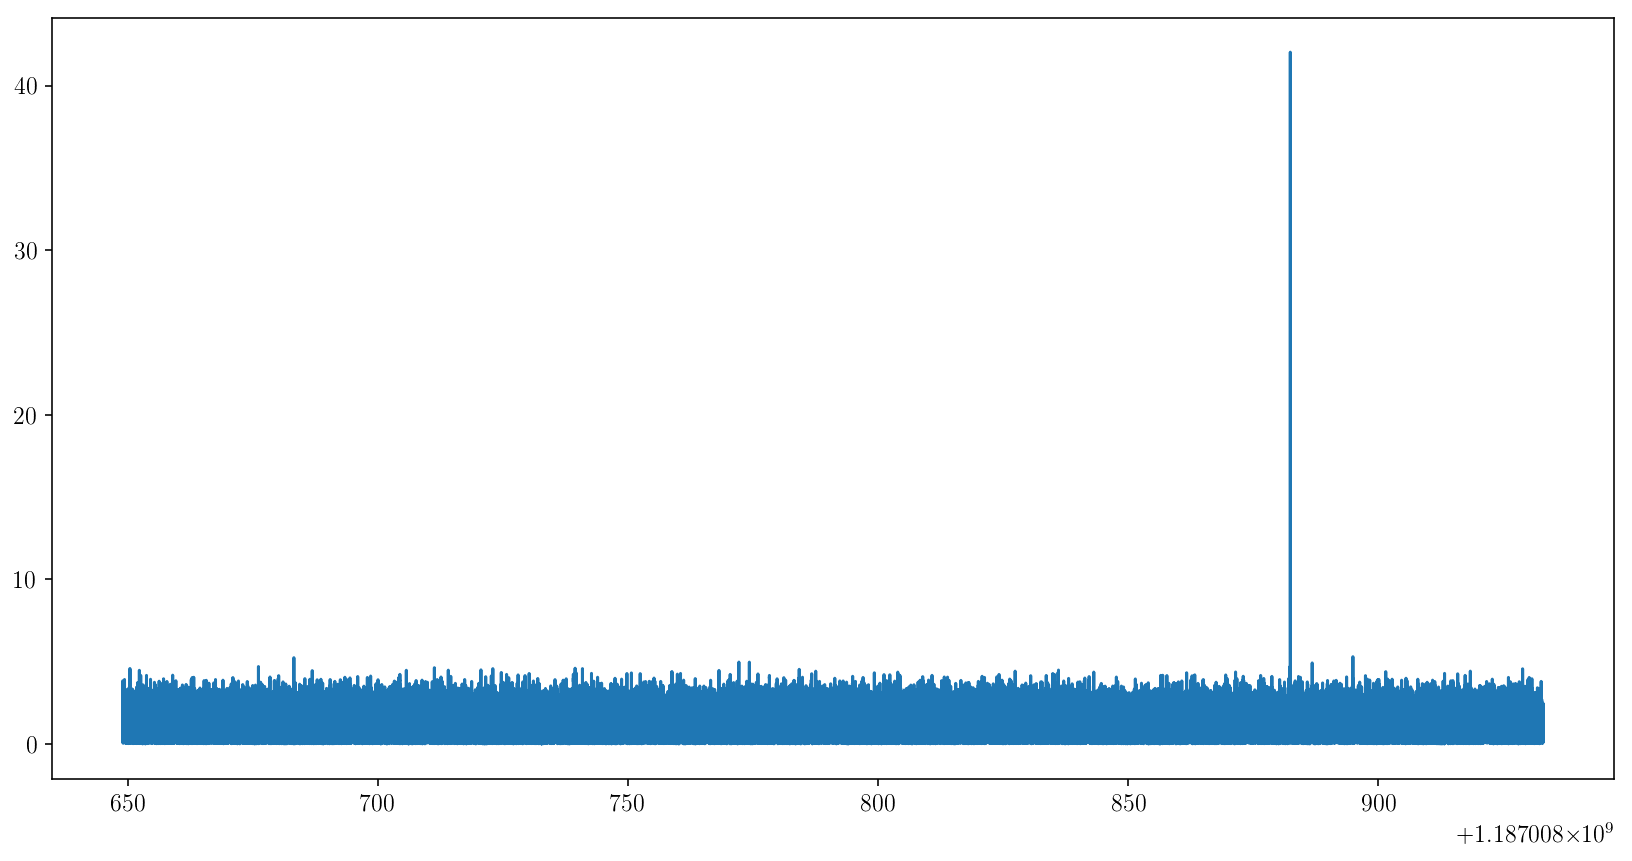

At 22.540 Mpc, SNR in V1 is 42.027 at time 1187008882.4331
network_snr=183.501


In [7]:
instruments = ["H1", "L1", "V1"]
injections_file = 'injection_GW170817.hdf'
gps_start_time = 1187008641
gps_end_time = 1187008941
sample_rate = 4096
low_frequency_cutoff = 20
output_file = 'gw170817_inj.hdf'

def inject_and_filter(params, noise_strain, psd_dict):
    # set initial distance so signal will be loud
    #logging.info("Setting initial distance to {} Mpc".format(float(initial_distance)))
    
    params['ra'] = 4.25460328757
    params['dec'] = -0.573656562718
    params['lambda1'] = 174
    params['lambda2'] = 478
    params['distance'] = 22.54
    # write injection file
    logging.info("Writing injection file")
    with h5py.File(output_file, "w") as fp:
        for p, v in params.items():
            fp.create_dataset(p, (1,), data=v)
    # generate template waveform
    logging.info("Generating template waveform")
    print("delta_f=", delta_f)
    hp, hc = get_fd_waveform(approximant=params['approximant'],
                             mass1=params['mass1'],
                             mass2=params['mass2'],
                             spin1z=params['spin1z'],
                             spin2z=params['spin2z'],
                             lambda1=params['lambda1'],
                             lambda2=params['lambda2'],
                             distance=params['distance'],
                             tc=params['tc'],
                             ra=params['ra'],
                             dec=params['dec'],
                             inclination=params['inclination'],
                             polarization=params['polarization'],
                             coa_phase=params['coa_phase'],
                             f_lower=params['f_lower'],
                             f_ref=params['f_ref'],
                             delta_f=delta_f)
    
    network_snr = 0.0
    tcs = {}
    for ifo in instruments:
        # make injection into noise
        logging.info("Injecting waveform into {} noise".format(ifo))
        signal_strain = noise_strain[ifo].copy()
        psd = psd_dict[ifo].copy()
        injector = InjectionSet(output_file)
        injector.apply(signal_strain, ifo)
        injector._injhandler.filehandler.close()
        # matched filter template with injected signal to check SNR
        logging.info("Matched filtering template against injected signal")
        if signal_strain.delta_f != psd.delta_f:
            logging.info("Interpolating PSD")
            psd = _psd.interpolate(psd, signal_strain.delta_f)
        signal_strain = signal_strain.to_frequencyseries()
        hp.resize(len(signal_strain))
        snr_series = matched_filter(hp, signal_strain, psd=psd,
                                    low_frequency_cutoff=params['f_lower'])
        
        snr_series = snr_series.time_slice(gps_start_time+8, gps_end_time-8)
        plt.plot(snr_series.sample_times, abs(snr_series))
        plt.show()
        snr, loc = snr_series.abs_max_loc()
        print("At {:.3f} Mpc, SNR in {} is {:.3f} at time {:.4f}".format(params['distance'], ifo, snr, snr_series.sample_times[loc]))
        tcs[ifo] = snr_series.sample_times[loc]
        network_snr += snr ** 2
        
    print("network_snr={:.3f}".format(numpy.sqrt(network_snr)))
        
    return numpy.sqrt(network_snr)
    
    
    
fp=h5py.File(injections_file,'r')

params={}
for sa in fp.attrs['static_args']:
    params[sa] = fp.attrs[sa]
    params['approximant'] = fp.attrs['approximant']
    params['f_lower'] = fp.attrs['f_lower']
    params['f_ref'] = fp.attrs['f_ref']

td_samples = (gps_end_time - gps_start_time) * sample_rate
fd_samples = int(td_samples // 2) + 1
delta_t = 1./sample_rate
delta_f = 1./(float(td_samples) * delta_t)


psd_dict = {}
psd_dict['H1'] = _psd.aLIGODesignSensitivityP1200087(fd_samples, delta_f, low_frequency_cutoff)
psd_dict['L1'] = _psd.aLIGODesignSensitivityP1200087(fd_samples, delta_f, low_frequency_cutoff)
psd_dict['V1'] = _psd.AdVDesignSensitivityP1200087(fd_samples, delta_f, low_frequency_cutoff)

# generate colored gaussian noise
logging.info("Generating colored gaussian noise")
noise_strain = {}
seed=1
for ifo in instruments:
    noise_strain[ifo] = colored_noise(psd_dict[ifo], gps_start_time,
                                      gps_end_time,seed=seed,
                                      low_frequency_cutoff=low_frequency_cutoff)
    noise_strain[ifo] = resample_to_delta_t(noise_strain[ifo],delta_t=delta_t)
    seed+=1


network_snr = inject_and_filter(params, noise_strain,
                                psd_dict)

## Plot qscans

In [13]:
!pycbc_plot_qscan --time-windows 50,10 10,1 1,1 \
    --strain-high-pass 15 --sample-rate 4096 --pad-data 8 \
    --frame-files H1-HWINJ-1187006850-4064.gwf \
    --channel-name H1:HWINJ_INJECTED \
    --gps-start-time 1187008641 --gps-end-time 1187008941 \
    --center-time 1187008882.0 --output-file "test.png"

2019-04-06 11:16:52,981 Reading Frames
2019-04-06 11:17:02,959 Highpass Filtering
2019-04-06 11:17:03,038 Converting to float32
2019-04-06 11:17:03,043 Resampling data
2019-04-06 11:17:03,045 Highpass Filtering
2019-04-06 11:17:03,112 Remove Padding
/home/soumi.de/pycbc-dev5/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


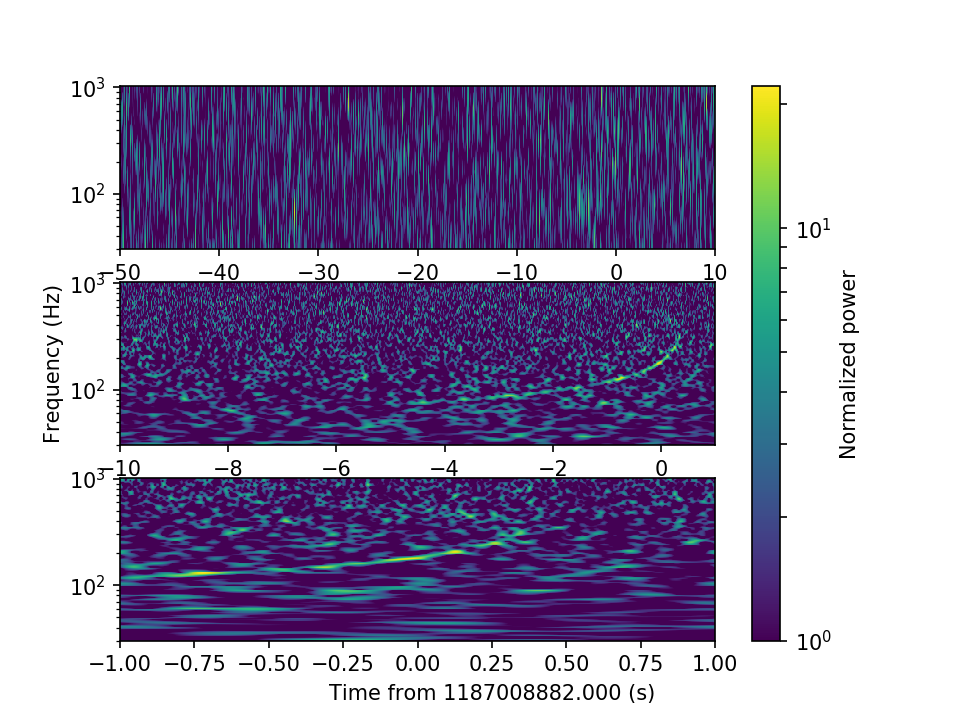

In [16]:
Image('test.png')